In [1]:
import mne
from Python_Processing.Data_extractions import  extract_data_from_subject
from Python_Processing.Data_processing import  select_time_window, transform_for_classificator

In [2]:
### Hyperparameters

# The root dir has to point to the folder that contains the database
root_dir = "../data/"

# Data Type
datatype = "EEG"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

# Subject number
N_S = 1   #[1 to 10]

In [3]:
#@title Data extraction and processing

# Load all trials for a single subject
X, Y = extract_data_from_subject(root_dir, N_S, datatype)

# Cut useful time. i.e action interval
X_yes = select_time_window(X = X, t_start = 2.0, t_end = 2.5, fs = fs)
X_no = select_time_window(X = X, t_start = 4.0, t_end = 4.5, fs = fs)

In [4]:
print("Data shape: [trials x channels x samples]")
print(X_yes.shape) # Trials, channels, samples
print(X_no.shape) # Trials, channels, samples

print("Labels shape")
print(Y.shape) # Time stamp, class , condition, session

Data shape: [trials x channels x samples]
(500, 128, 128)
(500, 128, 128)
Labels shape
(500, 4)


In [5]:
# Conditions to compared
# Conditions = [["PRON"],["PRON"],["PRON"],["PRON"]]
Conditions = [["IN"],["IN"],["IN"],["IN"]]
# The class for the above condition
Classes    = [  ["Up"] ,["Down"],["Left"],["Right"] ]

In [6]:
# Transform data and keep only the trials of interes
X_yes , Y =  transform_for_classificator(X_yes, Y, Classes, Conditions)

In [7]:
import numpy as np

In [8]:
X_all = np.concatenate([X_yes, X_no[:50]], axis=0)
y_all = np.concatenate([Y, np.full(50, 4)])

In [9]:
print("Final data shape")
print(X_all.shape)

print("Final labels shape")
print(y_all.shape) 

Final data shape
(250, 128, 128)
Final labels shape
(250,)


In [10]:
n_epochs = 250
n_channels = 128      # チャンネル数
n_samples = 128      # サンプル数
sfreq = 256           # サンプリング周波数 (Hz)
ch_names = [f'EEG {i+1}' for i in range(n_channels)]  # チャンネル名のリスト
ch_types = ['eeg'] * n_channels                        # 各チャンネルのタイプを'eeg'に設定
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
event_ids = {f'event_{i + 1}': i + 1 for i in range(n_epochs)}
events = np.array([[i, 0, i+1] for i in range(n_epochs)])  # 各エポックにイベントID
epochs = mne.EpochsArray(X_all, info, events=events, event_id=event_ids)

Not setting metadata
250 matching events found
No baseline correction applied
0 projection items activated


In [11]:
from mne.time_frequency import tfr_multitaper

# 仮のデータロード（または、epochsオブジェクトを用意）
# epochs = mne.Epochs(...)  # 既にエポックデータがある場合

# 時間周波数解析のパラメータ設定
frequencies = np.arange(1, 40, 1)  # 解析する周波数範囲（1Hzから40Hz）
n_cycles = frequencies / 2.  # 周波数ごとのサイクル数（調整可能）

# # マルチターパー法で時間周波数解析
# power = tfr_multitaper(epochs, freqs=frequencies, n_cycles=n_cycles, use_fft=True,
#                        return_itc=False, decim=3, n_jobs=1)


In [12]:
tfr = epochs.compute_tfr(method="multitaper", freqs=frequencies, n_cycles=n_cycles)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:   28.7s


In [13]:
tfr.data.shape

(250, 128, 39, 128)

In [14]:
import matplotlib.pyplot as plt

No baseline correction applied


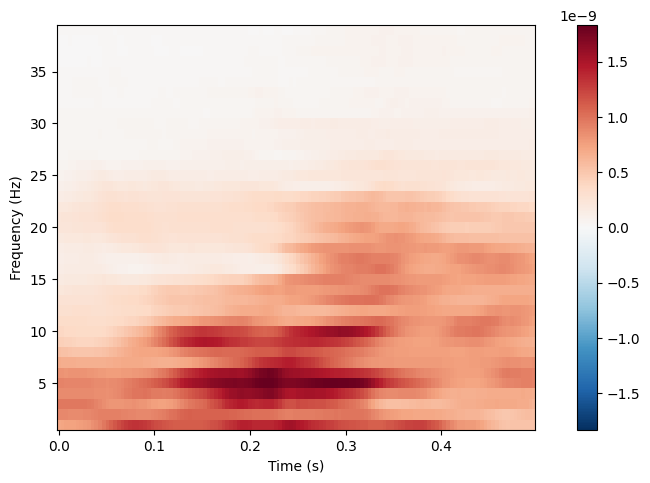

[<Figure size 640x480 with 2 Axes>]

In [28]:
tfr[233].plot(picks="EEG 8")

In [87]:
spec_raw = tfr.data[:,:,:,::4]

In [88]:
spec_raw = spec_raw.reshape(spec_raw.shape[0], -1)

In [89]:
signal_raw = X_all.reshape(X_all.shape[0], -1)

In [109]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [126]:
tsne_signal = TSNE(n_components=2, random_state=42)
pca_signal = PCA(n_components=100)
tsne_spec = TSNE(n_components=2, random_state=42)
pca_spec = PCA(n_components=100)
signal_raw_tsne = tsne_signal.fit_transform(StandardScaler().fit_transform(signal_raw))
signal_raw_pca = pca_signal.fit_transform(StandardScaler().fit_transform(signal_raw))
spec_raw_tsne = tsne_spec.fit_transform(StandardScaler().fit_transform(spec_raw))
spec_raw_pca = pca_spec.fit_transform(StandardScaler().fit_transform(spec_raw))

In [117]:
pca_spec.explained_variance_ratio_

array([0.13524193, 0.0576266 ])

In [121]:
pca_signal.explained_variance_ratio_

array([0.0980087 , 0.06558235])

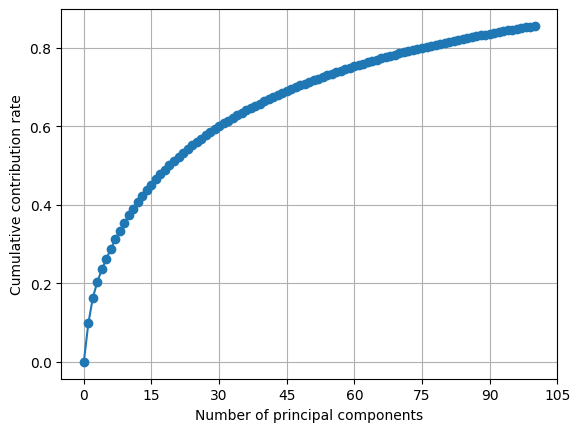

In [127]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca_signal.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [ ]:
mapping = {0:"Up", 1:"Down", 2:"Right", 3:"Left", 4:"Normal"}
y_name = np.vectorize(mapping.get)(y_all)

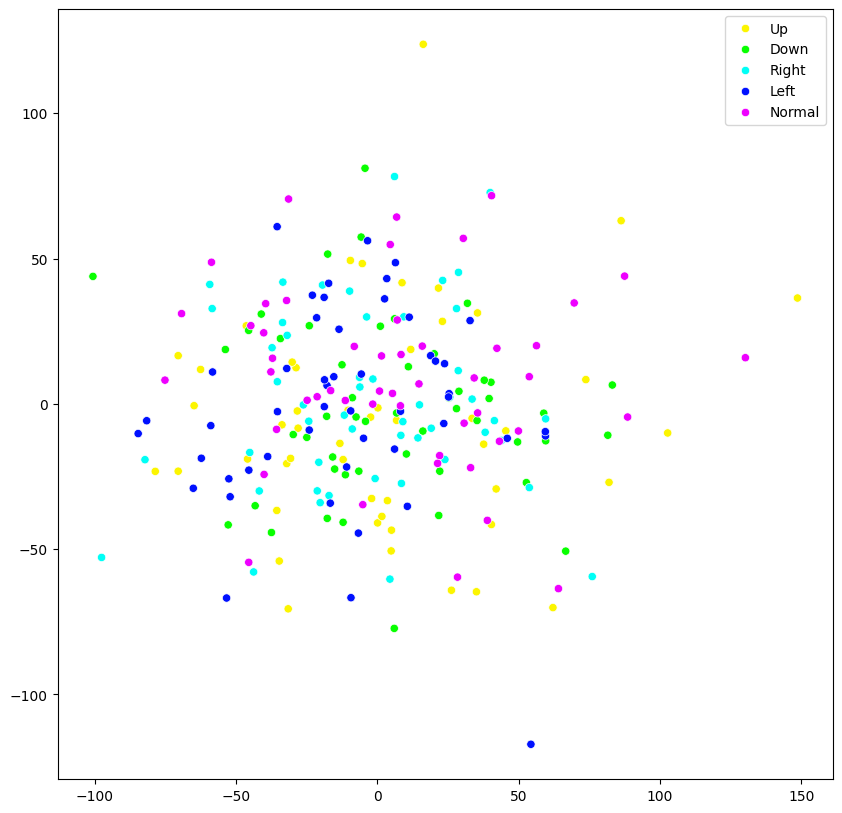

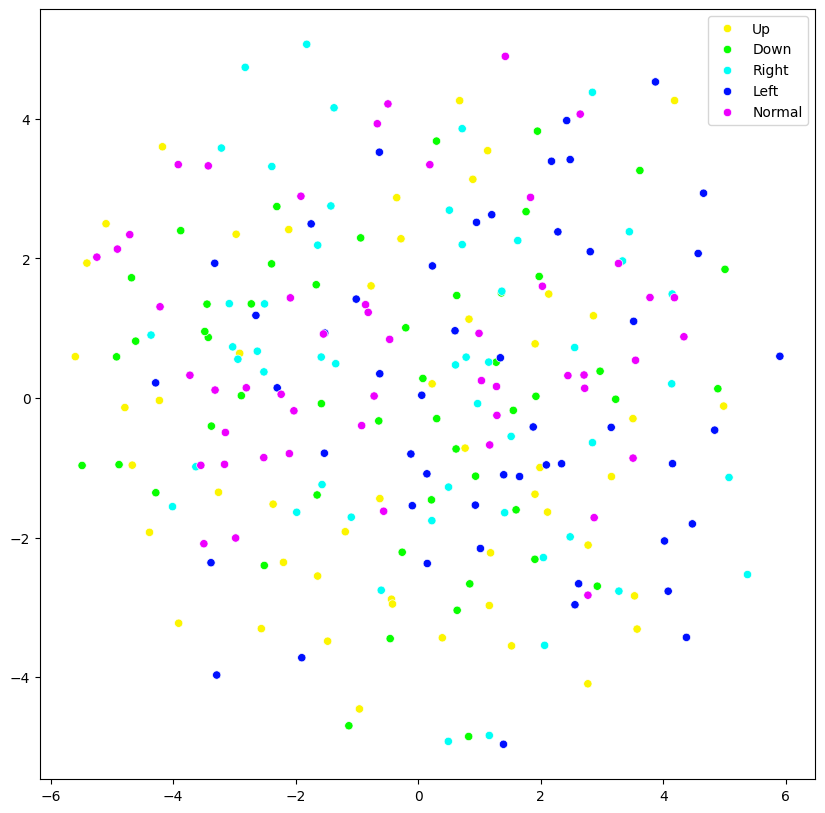

In [124]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=signal_raw_pca[:, 0], y=signal_raw_pca[:, 1], hue=y_name, palette=sns.color_palette("hsv", 5))
plt.show()
plt.figure(figsize=(10, 10))
sns.scatterplot(x=signal_raw_tsne[:, 0], y=signal_raw_tsne[:, 1], hue=y_name, palette=sns.color_palette("hsv", 5))
plt.show()

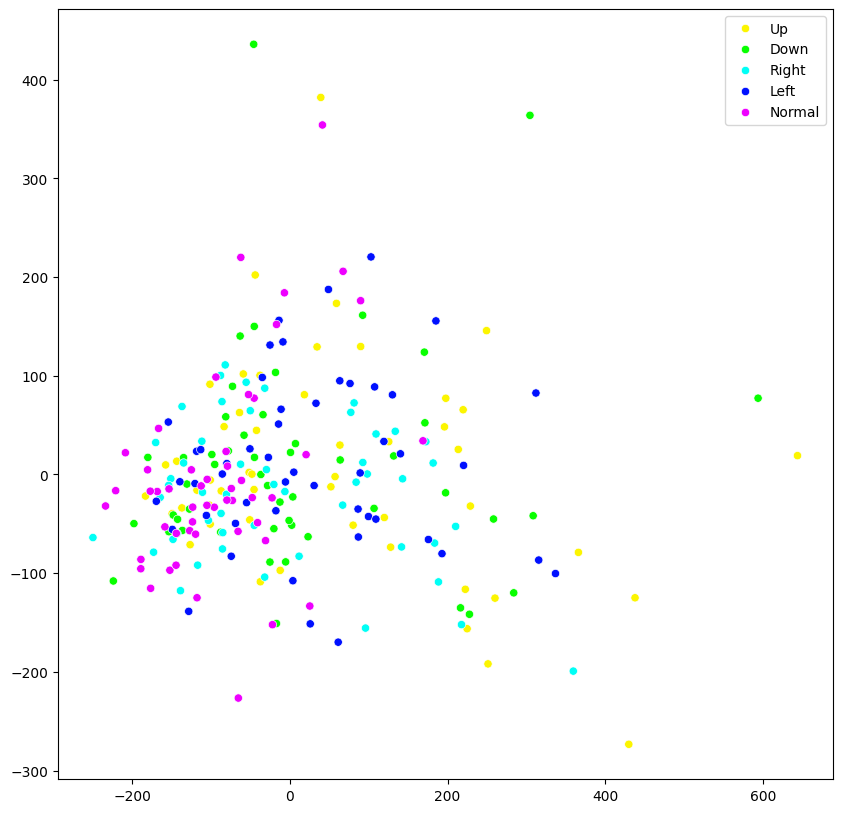

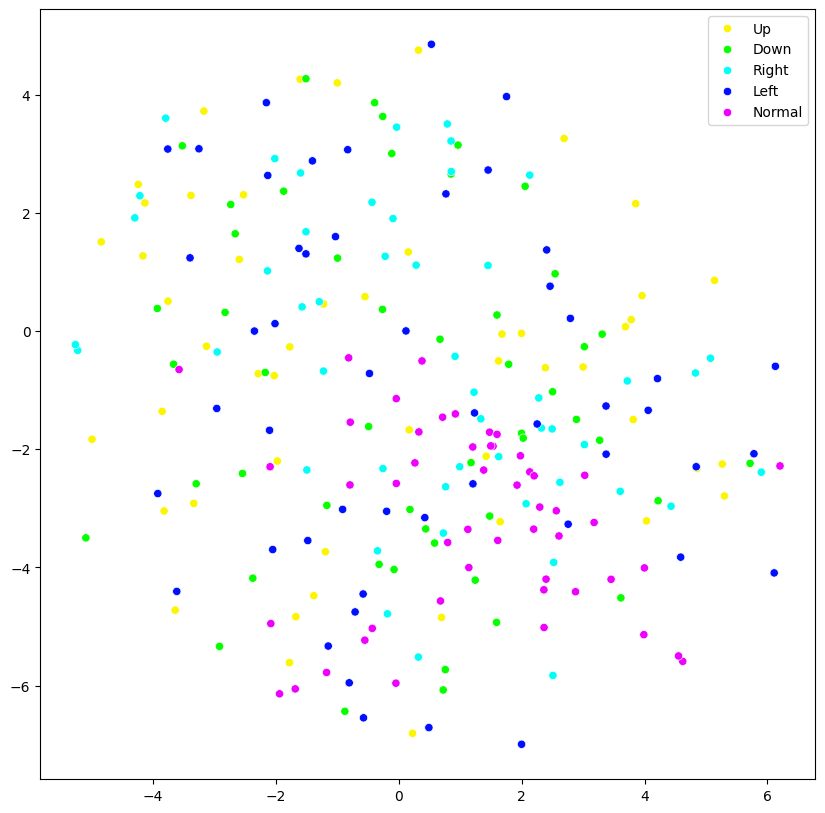

In [125]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=spec_raw_pca[:, 0], y=spec_raw_pca[:, 1], hue=y_name, palette=sns.color_palette("hsv", 5))
plt.show()
plt.figure(figsize=(10, 10))
sns.scatterplot(x=spec_raw_tsne[:, 0], y=spec_raw_tsne[:, 1], hue=y_name, palette=sns.color_palette("hsv", 5))
plt.show()